In [3]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


In [4]:
batch_size = 128
img_height = 129
img_width = 515

train_ds = tf.keras.utils.image_dataset_from_directory(
	"birds",
	validation_split=0.2,
	subset="training",
	seed=123,
	image_size=(img_height, img_width),
	batch_size=batch_size,
	color_mode="grayscale")

val_ds = tf.keras.utils.image_dataset_from_directory(
	"birds",
	validation_split=0.2,
	subset="validation",
	seed=123,
	image_size=(img_height, img_width),
	batch_size=batch_size,
	color_mode="grayscale")


print(train_ds.class_names)
class_names = train_ds.class_names

Found 5422 files belonging to 5 classes.
Using 4338 files for training.
Found 5422 files belonging to 5 classes.
Using 1084 files for validation.
['American_Robin', "Bewick's_Wren", 'Northern_Cardinal', 'Northern_Mockingbird', 'Song_Sparrow']


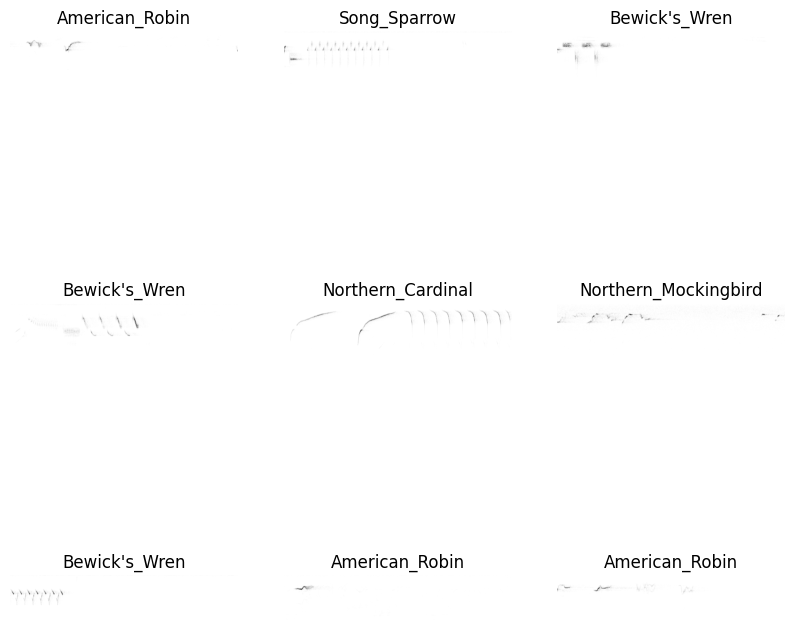

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"), cmap="gray")
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 129, 515, 1)       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 129, 515, 16)      160       
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 64, 257, 16)       0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 64, 257, 16)       2320      
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 32, 128, 16)       0         
 ng2D)                                                           
                                                                 
 conv2d_18 (Conv2D)          (None, 32, 128, 16)      

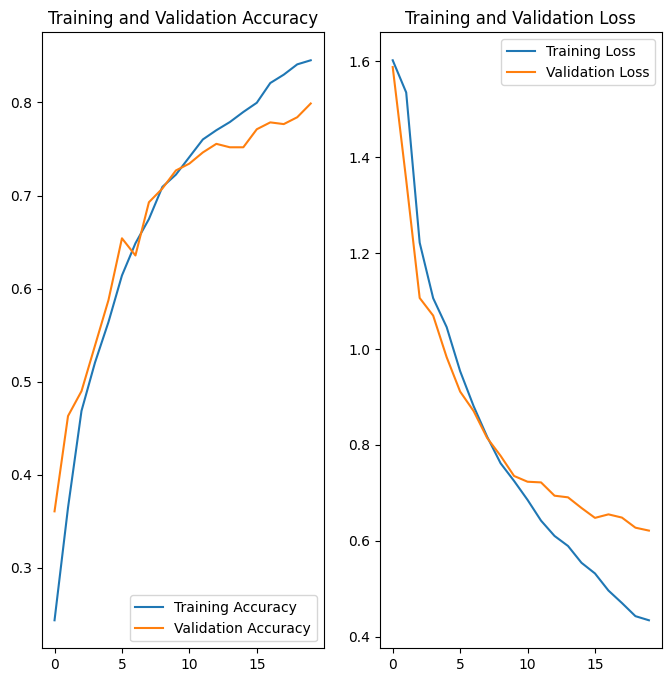

In [30]:
num_classes = len(class_names)

# 74 % val acc
model = Sequential([
	layers.Rescaling(1./255, input_shape=(img_height, img_width, 1)),
	layers.Conv2D(16, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),
	layers.Conv2D(16, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),
	layers.Conv2D(16, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),
	layers.MaxPooling2D(),
	layers.MaxPooling2D(),
	layers.Flatten(),
	layers.Dense(64, activation='relu'),
	layers.Dense(num_classes)
])

model.compile(
	optimizer='adam',
	loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
	metrics=['accuracy']
)

model.summary()

epochs=20
history = model.fit(
	train_ds,
	validation_data=val_ds,
	epochs=epochs
)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [31]:
# model.save("birds_74.h5")
model.save("birds.keras")

In [32]:
import tensorflow as tf

# Load model
model = tf.keras.models.load_model("birds.keras")

In [33]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

open("tflite_model/birds_model.tflite",  "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp98uqd0dg/assets


INFO:tensorflow:Assets written to: /tmp/tmp98uqd0dg/assets
2024-05-02 13:37:21.114731: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-02 13:37:21.114778: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-02 13:37:21.115084: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp98uqd0dg
2024-05-02 13:37:21.117380: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-02 13:37:21.117398: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp98uqd0dg
2024-05-02 13:37:21.124071: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-05-02 13:37:21.194373: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp98uqd0dg
2024-05-02 13:37:21.217105: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

77576

In [22]:
from tensorflow.lite.python.util import convert_bytes_to_c_source

source_text, header_text = convert_bytes_to_c_source(tflite_model,  "tflite_model/bird_model")

with  open('tflite_model/bird_model.h',  'w')  as  file:
    file.write(header_text)

with  open('tflite_model/bird_model.cc',  'w')  as  file:
    file.write(source_text)
